# Blind Image Separation

## Problem statement
The purpose of the project is to separate an image obtained as a sum of a two images into its components. 

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2. 

The metric used to evaluate the project is the mean squared error between predicted and ground truth images.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split

import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
mnist_x_train, mnist_x_val, mnist_y_train, mnist_y_val = train_test_split(mnist_x_train, mnist_y_train, test_size=0.15)
print(np.shape(mnist_x_train))

(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
fashion_mnist_x_train, fashion_mnist_x_val, fashion_mnist_y_train, fashion_mnist_y_val = train_test_split(fashion_mnist_x_train, fashion_mnist_y_train, test_size=0.15)

#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_val = np.pad(mnist_x_val, ((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.

fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_val = np.pad(fashion_mnist_x_val,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11501568/11490434 [==============================] - 2s 0us/step
(51000, 28, 28)
4431872/4422102 [==============================] - 0s 0us/step
(51000, 32, 32)


In [ ]:
print(np.shape(mnist_x_train))

(51000, 32, 32)


Here is a simple datagenerator.

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

Here we define two generators, one for training and one for testing. You may possibly add an addition generator for validation, further splitting the dataset.

In [ ]:
batchsize = 64
inputShape = (32,32,1)

In [ ]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,1)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

Let us look at some input-output pairs

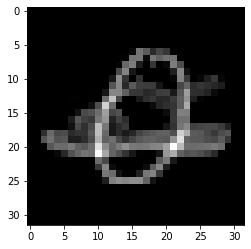

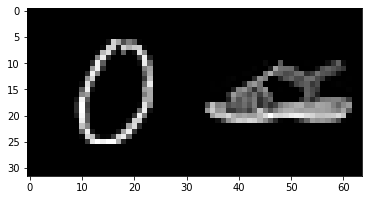

In [ ]:
x, y = next(train_generator)
plt.imshow(x[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

## Some considerations about generators and batch size
Doing a lot of tests I saw that the right batch size for the train and validation generators is around 32/64 and generally a small batch size is suggested because it may lead to [better results](https://arxiv.org/abs/1804.07612).    
The following model can reach a good score also with 500 steps per epoch, but I got the best score for my model considering a batch size of 32 and 6500 steps per epoch. I fed the model with a lot of data and this improves the final result.

Moreover [generators help](https://www.lachlaneagling.com/reducing-memory-consumption-python/) in avoid memory consumption because they don't load all the values into memory at one time and this allows me to use a lot of samples during the training. The drawback is that we have a longer runtime due to the higher number of function calls.

## Model inspiration and ideas
The first idea that comes to my mind is to implement a [UNET](https://arxiv.org/pdf/1505.04597.pdf) because it's a a U-shaped encoder-decoder network architecture that can help me to extract the features of the 2 different images and then it can reconstructs them separately. 
<div align="center">
    <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png" width="450px">
</div>

#### Encoder 
The encoder part acts as a feature extractor and learns an abstract representation of the input image through a sequence of encoder blocks (which contain two 3x3 convolutions), which are activated by the ReLU function in order to have a better generalization of the training data. These blocks are followed by a 2x2 max-pooling layer in order to reduce the spatial dimension of the feature maps.

#### Skip Connections
There are skip connections between encoder and decoder blocks that provide additional information and help the decoder to generate better semantic features. They also act as a shortcut connection that helps in the direct flow of gradients to the earlier layers without any degradation. In simple terms, we can say that skip connection helps in better flow of gradient while backpropagation, which in turn helps the network to learn better representation and stabilizes training.
A different usage of the skip connections can be seen in the [ResNet](https://arxiv.org/pdf/1512.03385v1.pdf) implementation, where the researchers implemented skip connections through addition.

#### Decoder
The decoder network is used to take the abstract representation and generate a semantic segmentation mask. The decoder block starts with a 2×2 transpose convolution. Next, it is concatenated with the corresponding skip connection feature map from the encoder block. These skip connections provide features from earlier layers that are sometimes lost due to the depth of the network. After that, two 3×3 convolutions are used, where each convolution is followed by a ReLU activation function. 
The output of the last decoder passes through a 1×1 convolution with sigmoid activation. The sigmoid activation function gives the segmentation mask representing the pixel-wise classification.

Between the encoder and the decoder part there is a bridge that is composed by two 3x3 convolutions.

## Model implementation and code
My model is basically a UNET with a reduced number of encoder and decoder blocks. Since we need to separate 2 images that are very simple due to the low resolution I decided to implement a simpler version of the original network. 
I use only 2 encoder and decoder blocks with 2 convolutions per block, the bridge to connect them and the skip connections but I start with a high number of filters already from the first layer, 128.   
Moreover I decided to add the batch normalization layers according to the previous paragraph.

### Implementation choices
- OUTPUT:   
In my case I need to perform some changes in order to make the model return the 2 different images concatenated. We need this because the ground truth images are the concatenation of the 2 original images and so they are unique 32x64 images. In order to achieve this result I simply add 2 different convolutions at the end of the net (removing the original one), with 1 channel (because our images are in grayscale), strides=1 and the sigmoid as activation function. After that I get 2 different outputs for the different images I concatenate the two images into one and I get a 32x64 image as output.   
In this last concatenate layer I set the dtype to 'float32' because I used [mixed precision](https://www.tensorflow.org/guide/mixed_precision?hl=en) in order to enhance the GPU's performances.

- LAYERS:   
In the original paper the UNET implementation did not include neither batch normalization nor dropout layers but in the following years researchers found that these layers can enhance the model. I tried a lot of different versions of the UNET and in my opinion I can get the best results using batch normalization layers in between the convolution layers and the activation function. [Batch normalization](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/) reduces internal covariance shift and make the network more stable while training.  
If we add some dropout layers after the max-pooling and the concatenate layers we completely remove overfitting but it seems that the model learns slower and a bit of underfitting appears, hence probably is better to avoid dropout in this case.

- LEARNING RATE:         
It's really important to set the correct learning rate to get the best from the model and to avoid either the gradient descent overshooting of the minimum or a very slow descent. I use the 'ReduceLR' callback for decreasing it after that the model does not improve for some epochs. Considering several trials I think that in my case the best updating factor is around 0.4 with a patience of 4 or 5 epochs and I start with a learning rate equal to 1e-03.

First of all I added a validation set to the code provided by the professor such that I can compute the validation loss during the training. At this point I can create 3 different generators for training, validation and test sets, the first 2 with batch size equal to 32, because I saw that it is a good size for our model and a batch of 1024 for the test because I need to use it only at the end for the evaluation.

In [ ]:
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, 32)
val_generator = datagenerator(mnist_x_val, fashion_mnist_x_val, 32)
test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, 1024)

Now I import all the layers, the callbacks and the optimizer that I need for creating and training the model.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Conv2DTranspose, concatenate, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

I created 2 different functions for the construction of an encoder block and a decoder block and I added the *BatchNormalization* layers.

In [ ]:
def encoder_block(inputs, id_layer, n_blocks, n_ch, conv_per_b, backup_layers, decoder=False):
    """
    Args:
        inputs: image in the first layer and the output of a layer in the following one.
        id_layer: (int) the number of the current block in the structure. E.g. the first block has 'id_layer' equal to 0
                        and so on.
        n_blocks: (int) the number of blocks in the encoder part of the model. Actually if 'n_blocks' is n the model
                        create n-1 encoder and decoder blocks because this number also includes the bridge.
        n_ch: (int) the number of filters to use in the Conv2D layer.
        conv_per_b: (int) the number of Conv2D layers used in each block.
        backup_layers: the list of encoder layers to connect through skip connections.
        decoder: (bool) This variable is False by default and can be set to True to avoid the MaxPooling and other operations
                        not required if the function is used in the decoder part of the model.
    Returns:
        keras.models.Model instance
    """
    h = inputs
    for i in range(conv_per_b):
        h = Conv2D(n_ch, 3, 1, padding='same')(h)
        h = BatchNormalization()(h)
        h = ReLU()(h)

    if not(decoder) and (id_layer < n_blocks-1):
        backup_layers.append(h)
        h = MaxPooling2D(padding='same')(h)
        n_ch = n_ch * 2

    return h, n_ch


def decoder_block(inputs, id_layer, n_blocks, n_ch, conv_per_b, backup_layers):
    n_ch = n_ch // 2
    h = Conv2DTranspose(n_ch, 3, 2, padding='same')(inputs)
    # Skip connection
    h = concatenate([h, backup_layers.pop(-1)])
    # Convolutions
    h, _ = encoder_block(h, id_layer, n_blocks, n_ch, conv_per_b, backup_layers, decoder=True)
    
    return h, n_ch


def build_model(input_shape, n_ch=32, blocks=4, conv_per_b=2):
    """
    Args:
        inputs_shape: (tuple) A tuple that represents the shape of the images in input.
        n_ch: (int) the number of filters to start from in the Conv2D layers.
        blocks: (int) the number of blocks in the encoder and decoder parts of the model. This number also includes the
                      bridge, so the number of actual implemented blocks is 'blocks'- 1.
        conv_per_b:  the number of Conv2D layers used in each block. By default is 2 like in the original implementation.
    Returns:
        keras.models.Model instance
    """
    x = Input(shape=input_shape)
    # Encoder part
    backup_layers = []
    h = x
    for b in range(blocks):
        # Create the encoder blocks
        h, n_ch = encoder_block(h, b, blocks, n_ch, conv_per_b, backup_layers, decoder=False)

    # Decoder part
    for b in range(blocks-1):
        h, n_ch = decoder_block(h, b, blocks, n_ch, conv_per_b, backup_layers)

    # Output
    out1 = Conv2D(1, 1, activation='relu')(h)
    out2 = Conv2D(1, 1, activation='relu')(h)
    y = Concatenate(axis=2, dtype="float32")([out1, out2])
    return Model(x, y)

    
model = build_model(input_shape=(32, 32, 1), n_ch=128, blocks=3, conv_per_b=2)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 128)  1280        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 128)  512        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 128)  0           ['batch_normalization[0][0]']

As you can see from the summary the model has almost 8.2 million parameters and in the following cell I print the structure of the model, that is obviously similar to the UNET shape.

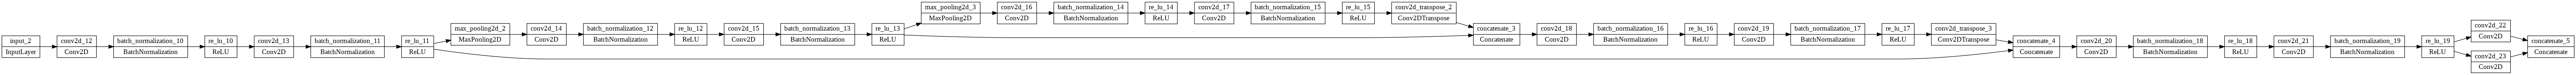

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, rankdir="LR")

As I said before I start from a learning rate equal to 1e-3 with *Adam* optimizer and I use 2 callbacks in order to stop the training once the validation loss stops to decrease and to modulate the learning rate always considering the validation loss value. The considered loss function is the mean squared error as said in the problem statement.

- The ***EarlyStopping*** callback is very useful because it stops the training once the validation loss, or a metric that you can indicate, stops to decrease/increase. In my case I set a big limit for the number of epochs but after 61 the training stopped because the validation loss was not improved of at least 1e-6 for 8 consecutive epochs. 

- The ***ReduceLR*** callback is the key for a good training, because it modulates the learning rate of the optimizer and it's fundamental to have the right value for the learning rate in order to avoid too big jumps or too small ones.

Using a batch size equal to 32 in the generators for the training and validation set I decide to use a step size of 6500 and 500 accordingly. This huge quantity of samples allows the model to learn better but the computation takes obviously more time.

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mean_squared_error'])

early_stopping = EarlyStopping(monitor="val_loss", patience=8, min_delta=0.000001)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.4, patience=4, min_delta=0.000001, mode="min")

train_steps = 6500
val_steps = 500

history = model.fit(train_generator, epochs=200, steps_per_epoch=train_steps, validation_data=val_generator, validation_steps=val_steps, callbacks=[reduce_lr, early_stopping])

Epoch 1/200
6500/6500 [==============================] - 245s 37ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - lr: 0.0010
Epoch 2/200
6500/6500 [==============================] - 245s 38ms/step - loss: 9.9455e-04 - mean_squared_error: 9.9455e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - lr: 0.0010
Epoch 3/200
6500/6500 [==============================] - 246s 38ms/step - loss: 7.3873e-04 - mean_squared_error: 7.3873e-04 - val_loss: 6.1535e-04 - val_mean_squared_error: 6.1535e-04 - lr: 0.0010
Epoch 4/200
6500/6500 [==============================] - 241s 37ms/step - loss: 6.1470e-04 - mean_squared_error: 6.1470e-04 - val_loss: 5.2767e-04 - val_mean_squared_error: 5.2767e-04 - lr: 0.0010
Epoch 5/200
6500/6500 [==============================] - 240s 37ms/step - loss: 5.5611e-04 - mean_squared_error: 5.5611e-04 - val_loss: 5.1747e-04 - val_mean_squared_error: 5.1747e-04 - lr: 0.0010
Epoch 6/200
6500/6500 [================

After these 61 epochs the training stopped but the learning rate was quite high so I thought that the model could learn something more with a lower learning rate, thus I started a new training with learning rate 1e-5.

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mean_squared_error'])

early_stopping = EarlyStopping(monitor="val_loss", patience=8, min_delta=0.000001)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.4, patience=4, min_delta=0.000001, mode="min")

train_steps = 6500
val_steps = 500

history = model.fit(train_generator, epochs=200, steps_per_epoch=train_steps, validation_data=val_generator, validation_steps=val_steps, callbacks=[reduce_lr, early_stopping])

Epoch 1/200
6500/6500 [==============================] - 248s 38ms/step - loss: 2.8278e-04 - mean_squared_error: 2.8278e-04 - val_loss: 2.9568e-04 - val_mean_squared_error: 2.9568e-04 - lr: 1.0000e-05
Epoch 2/200
6500/6500 [==============================] - 244s 38ms/step - loss: 2.8391e-04 - mean_squared_error: 2.8391e-04 - val_loss: 2.8978e-04 - val_mean_squared_error: 2.8978e-04 - lr: 1.0000e-05
Epoch 3/200
6500/6500 [==============================] - 242s 37ms/step - loss: 2.8328e-04 - mean_squared_error: 2.8328e-04 - val_loss: 2.9108e-04 - val_mean_squared_error: 2.9108e-04 - lr: 1.0000e-05
Epoch 4/200
6500/6500 [==============================] - 246s 38ms/step - loss: 2.8331e-04 - mean_squared_error: 2.8331e-04 - val_loss: 2.9448e-04 - val_mean_squared_error: 2.9448e-04 - lr: 1.0000e-05
Epoch 5/200
6500/6500 [==============================] - 242s 37ms/step - loss: 2.8367e-04 - mean_squared_error: 2.8367e-04 - val_loss: 2.8589e-04 - val_mean_squared_error: 2.8589e-04 - lr: 1.0000

The model maybe learnt something new as we can see from the loss on the training set and probably it stabilized the error on validation set around 0.00029, but these 13 epochs were not very useful in my opinion.



In the following cell I plot the MSE for the training and the validation sets during the training and then I analyze the results obtained from my model in 61 + 13 epochs.

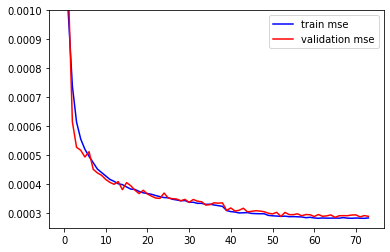

In [ ]:
def plot_history(history):
    plt.plot(history['mean_squared_error'], c='b', label='train mse')
    plt.plot(history['val_mean_squared_error'], c='r', label='validation mse')
    plt.legend(loc='upper right') 
    plt.ylim(0.00025, 0.001)
    plt.show()

plot_history(history)

As we can see from the chart there is almost no overfitting and at the beginning the validation set mse is even lower than the one on the training set.

It's relatively easy to get a mse error of 0.00035 but then the model needs another 30 epochs to reach the best result and decrease the error by almost 5e-05.

### Different approaches for training and different activation layers
- I tried to run the same model with batch equal to 64 and 3500 steps but with a factor of 0.5 and I was not able to reach the same results of my best model, probably due to its semplicity, the model can learn better with a smaller batch size even if the number of samples is almost the same.

- Another important modification is the activation function of the 2 output layers, at the beginning I used the sigmoid function but afterwards I realized that the sigmoid can not take values 0 or 1, and this could be a problem while working with images. So i tried to run the model with ReLU as activation function of the 2 ouput layers and I got my best result, even if the difference on the validation loss is almost null.

In the chart I show you the validation and the training losses of the model that have the sigmoid function in the output layers and the one with the ReLU in the output layers.

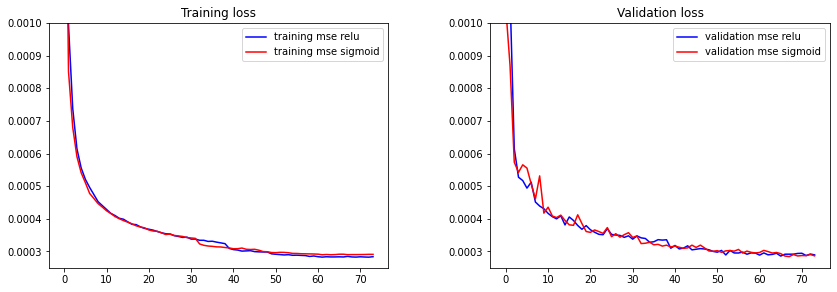

In [ ]:
def plot_comparison(history_relu, history_sigm):
    f = plt.figure(figsize=(14, 4.5))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    # Plot training mse
    ax.plot(history_relu['mean_squared_error'], c='b', label='training mse relu')
    ax.plot(history_sigm['mean_squared_error'], c='r', label='training mse sigmoid')
    ax.legend(loc='upper right') 
    ax.set_ylim(0.00025, 0.001)
    ax.set_title("Training loss")

    # Plot validation mse
    ax2.plot(history_relu['val_mean_squared_error'], c='b', label='validation mse relu')
    ax2.plot(history_sigm['val_mean_squared_error'], c='r', label='validation mse sigmoid')
    ax2.legend(loc='upper right') 
    ax2.set_ylim(0.00025, 0.001)
    ax2.set_title("Validation loss")

    plt.subplots_adjust(wspace=0.3)
    plt.show()

plot_comparison(history, history_sigm)

As you can see in the chart the difference between the val loss in the model that uses sigmoid and the one with the ReLU is a matter of 1e-6 and so in this case we probably can use both the activation functions reaching almost the same results. Also with the model that uses sigmoid I can reach 0.000306 of MSE average on 10 test sets.      
The model with the sigmoid function has a higher training loss and a lower validation loss but it performs worse on the test set than the model with the ReLU, that probably learnt to generalize better.

In the above cell the variable *history_sigm* is a variable in which I saved the history of the training that end in a worst MSE score (the one with sigmoids) and I have all values saved in a separate file.

## Model evaluation
The model reached a ***minimum*** MSE score of ***0.000296*** on a test set of 20 thousand samples.

The MSE average score on 20 thousand samples randomly created ten times by the test generator is **0.000299994**.      

The standard deviation between the different tests is **2.39e-06**.

For the test generator I use a batch size of 1024 therefore in the following function it's enough to perform 20 steps and to repeat the computation 10 times for computing the average and the standard deviation as recommended.

In [ ]:
def compute_mse(model, test_generator):
    res = []
    for i in range(10):
        metrics = model.evaluate(test_generator, steps=20)
        res.append(metrics[1])
    return res

pred_res = compute_mse(model, test_generator)
print(f"The average value of mse is: {np.mean(pred_res)}")
print(f"The standard deviation is: {np.std(pred_res)}")
print(f"The min value of mse is: {np.min(pred_res)}")

20/20 [==============================] - 5s 256ms/step - loss: 2.9669e-04 - mean_squared_error: 2.9669e-04
The average value of mse is: 0.0002999941789312288
The standard deviation is: 2.3891820286899574e-06
The min value of mse is: 0.000295668956823647


### Visual evaluation
I can also show how my model is able to visually separate the 2 images but even with higher MSE the result is good so it's not so meaningful in my opinion.

In [ ]:
batch_visual_gen = 8
visual_test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batch_visual_gen)

def visual_test(generator, model, n_images=1):
    x_test, y_test = next(generator)

    for i in range(n_images):
        print(f'\n --------- IMAGE {i+1} --------- \n')
        # Create the grid
        fig = plt.figure(figsize=(12, 8))
        grid = plt.GridSpec(2, 4, wspace=0.2, hspace=0.1)

        # Mixed image
        mixed_fig = fig.add_subplot(grid[0, 1])
        mixed_fig.axis('off')
        mixed_fig.set_title('Mixed image')
        mixed_fig.imshow(x_test[i], cmap='gray', interpolation='nearest')

        # Reconstructed image
        recons_fig = fig.add_subplot(grid[1, :2])
        recons_fig.axis('off')
        recons_fig.set_title('Reconstructed image')
        # Transform the test image into the right shape
        x, y = np.expand_dims(np.reshape(x_test[i], (32,32,1)), 0), y_test[i]   
        res = model.predict(x)
        recons_fig.imshow(np.reshape(res, (32,64)), cmap='gray', interpolation='nearest')
        
        # Groundtruth image
        orig_fig = fig.add_subplot(grid[1, 2:])
        orig_fig.axis('off')
        orig_fig.set_title('Groundtruth image')
        orig_fig.imshow(y, cmap='gray', interpolation='nearest')
        
        plt.show()


 --------- IMAGE 1 --------- 



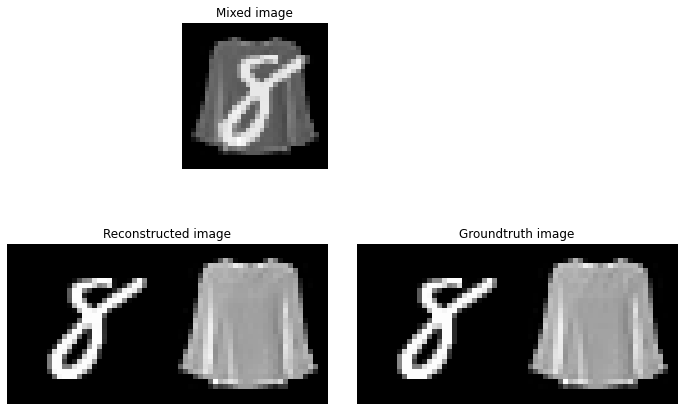


 --------- IMAGE 2 --------- 



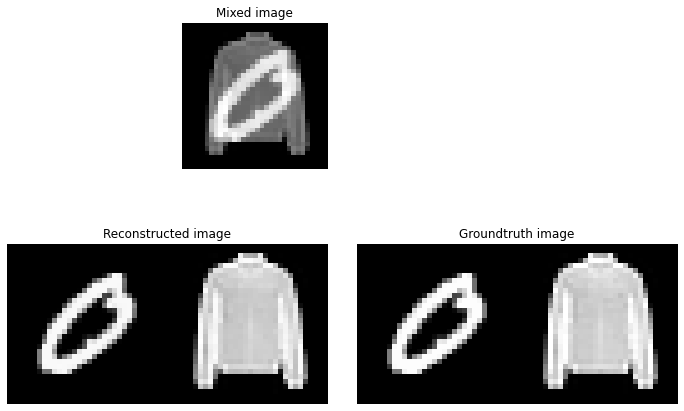

In [ ]:
visual_test(visual_test_generator, model, n_images=2)

## Comparison with SOTA
I tried to find out some interesting models that aim to solve a similar problem but I was not able to find anything so specific. A model that consider this problem is the BIDeN, a generative model explained in this [paper](https://arxiv.org/pdf/2108.11364.pdf) that examines Blind Image Decomposition.       
The researchers tested their model considering different tasks and the first one is "Mixed Image Decomposiion across multiple domains". They consider a more difficult problem because in their case the model can take as input an image composed by more than 2 different images, but they provide results also for the net that takes as input an image obtained by mixing up only 2 images.           
They compute the SSIM and PSNR and they used bigger images with 3 channels thus is quite difficult to perform a comparison between my model and BIDeN.

## Conclusions
- I tried a lot of different versions of the UNET, but it seems that the simpler the model is and the better it performs, so at the end I simplified the model in order to get a good MSE score.

- An important factor is the quantity of samples given through the training generator, increasing the number of steps per epoch lead to a better learning process, if the batch size is either 32 or 64.   
      
- The learning rate is very important too, if it doesn't decrease in the correct epoch it could ruin the training and so I spent a lot of time in finding the right parameters for the *ReduceLR* callback. 

- My best model is the one that you can check in the cell above, with the ReLU as activation function of the output layers and with a training considering 32 as batch size of the training and validation generators and with 6500 and 500 steps per epoch respectively. The training lasted 74 epochs.

- With my best model I was able to reach a minimum MSE score of 0.000296 on a single test set and 0.000299 on average on 10 test sets with 20 thousand samples.